In [30]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict

In [31]:
df = pd.read_excel("etf_combined.xlsx", index_col='Date', parse_dates=True)

# Calculate log normal returns for each ticker
df.columns = df.columns.str.strip()

log_returns = (np.log(df / df.shift(1))).dropna()

print(f"How many total tickers are there? {len(df.columns)}")   


How many total tickers are there? 25


In [32]:
# Calculate the covariance matrix
cov_matrix = log_returns.cov() * 252  # Annualized covariance matrix

# Calculate the correlation matrix
corr_matrix = log_returns.corr()


In [33]:
# Calculate the standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights # The @ operator is matrix multiplication
    return np.sqrt(variance)

# Calculate the expected return 3-yr
def expected_return(weights, log_returns):
    return np.sum(weights * log_returns.mean() * 252)

# Calculate the Sharpe ratio
risk_free_rate = 0.039
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [34]:
# As the scipy.optimize.minimize() function, we make our sharpe negative and minimise it

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


In [35]:
def list_excel_paths(
    root: Path,
    skip_dirs: List[str]
) -> List[Path]:
    """Return all .xlsx files under `root`, excluding any paths under skip_dirs."""
    excel_paths = []
    skip_set = set(skip_dirs)
    
    for path in root.rglob("*.xlsx"):
        # if any parent folder is in skip_dirs, skip it
        if skip_set.intersection(path.parts):
            continue
        excel_paths.append(path)
    return excel_paths

def tickers_by_asset(
    root: Path,
    skip_dirs: List[str]
) -> Dict[str, List[str]]:
    """
    Walk `root`, skip unwanted folders, then for each remaining .xlsx
    read the ticker (or fallback to filename), grouped by asset‐class folder.
    """
    files = list_excel_paths(root, skip_dirs)
    result: Dict[str, List[str]] = {}
    
    for file in files:
        relative = file.relative_to(root)
        asset_cls = relative.parts[0] 
        
        try:
            df = pd.read_excel(file)
            ticker = df["Ticker"].iloc[0] if "Ticker" in df.columns else file.stem
        except Exception as e:
            print(f"Couldn't read {file.name}: {e}")
            continue
        
        result.setdefault(asset_cls, []).append(ticker)
    
    return result

root_folder = Path("../raw")
skip = ["cash", "risk_free", "benchmarks", "retired"]

by_asset = tickers_by_asset(root_folder, skip)
print(by_asset)

# Map asset‐class tickers to DataFrame column indices
asset_indices: Dict[str, List[int]] = {
    cls: [df.columns.get_loc(t) for t in tickers if t in df.columns]
    for cls, tickers in by_asset.items()
}

print("Asset indices:", asset_indices)

{'bonds': ['EMHG', 'JGSA', 'CRHG LN', 'UBTP', 'AGGG LN'], 'alternatives': ['SGLN', 'VICI', 'DLR'], 'equities': ['WMVG LN ', 'MVEU LN Equity', 'SPMV LN', 'EMMV LN ', 'TECW LN', 'GOAIGBIV', nan, nan, nan, 'BGND4DS LX', nan, 'CUKX LN ', 'PSRU LN Equity', 'VUKE LN ', nan, 'IEFQ LN', nan]}
Asset indices: {'bonds': [0, 1, 2, 3, 4], 'alternatives': [5, 6, 7], 'equities': [9, 10, 12, 13, 17, 20, 23]}


In [42]:
asset_limits = {
    "equities":     0.40,
    "bonds":        0.35,
    "alternatives": 0.25,}

# Build per‐asset bounds by class
per_asset_cap = 0.10
n = len(df.columns)
# default: no‐short, fully investable
per_asset_bounds = [(0.01, per_asset_cap)] * n

for cls, class_max in asset_limits.items():
    cap = min(class_max, per_asset_cap)
    for idx in asset_indices.get(cls, []):
        per_asset_bounds[idx] = (0.0, cap)
bounds = tuple(per_asset_bounds)


# Rebuild your group‐sum constraints too
def make_group_constraint(indices, limit):
    return {
        "type": "ineq",
        "fun":   lambda w, idx=indices, L=limit: L - w[idx].sum()
    }

constraints = [
    {"type": "eq",   "fun": lambda w: w.sum() - 1.0},
    *[make_group_constraint(asset_indices[c], lim)
      for c, lim in asset_limits.items()]
]

# Initial guess; equal weights
n = len(df.columns)
initial_weights = np.ones(n) / n

# Now call minimize with both
result = minimize(neg_sharpe_ratio,
                  x0=initial_weights,
                  args=(log_returns, cov_matrix, risk_free_rate),
                  method="SLSQP",
                  bounds=bounds,
                  constraints=constraints)

optimal_weights = result.x

In [43]:
# 'SLSQP' is Sequential Least Squares Programming, which is a type of optimisation algorithm that is used to find the minimum of a function.
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimized_results.x # .x is the optimal value of the many attributes that 'optimized_results' function returns

In [44]:
# Print
print("Optimal weights: ")
for ticker, weight in zip(df.columns, optimal_weights):
    print(f"{ticker}: {weight:.4%}")
print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal portfolio return: {optimal_portfolio_return:.4%}")
print(f"Optimal portfolio volatility: {optimal_portfolio_volatility:.4%}")
print(f"Optimal portfolio Sharpe ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights: 
EMHG: 0.0000%
JGSA: 10.0000%
CRHG LN: 0.0000%
UBTP: 9.7117%
AGGG LN: 0.0000%
SGLN: 10.0000%
VICI: 0.0000%
DLR: 1.0073%
WMVG LN: 10.0000%
MVEU LN Equity: 10.0000%
SPMV LN: 3.2810%
EMMV LN: 1.0000%
TECW LN: 10.0000%
GOAIGBIV: 0.0000%
ARTGEIG LN: 10.0000%
PARAQPG LX: 1.0000%
GAMSUZA ID: 1.0000%
BGND4DS LX: 0.0000%
PIGEOZG LX: 1.0000%
CUKX LN: 10.0000%
PSRU LN Equity: 0.0000%
VUKE LN: 1.0000%
FFEDWGA LX: 1.0000%
IEFQ LN: 0.0000%
VGSESIE ID: 10.0000%

Optimal portfolio return: 10.8340%
Optimal portfolio volatility: 8.3152%
Optimal portfolio Sharpe ratio: 0.8339


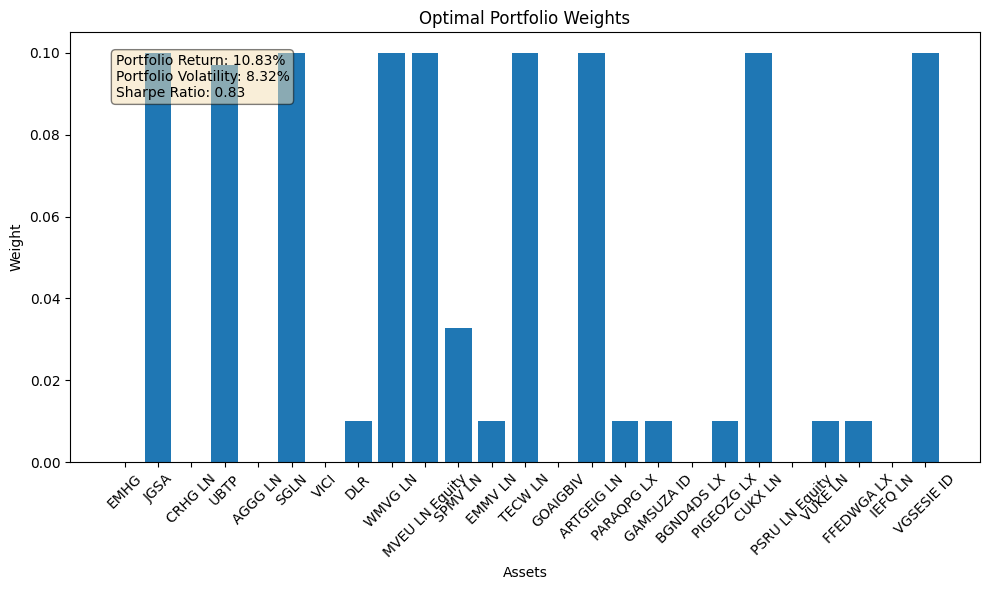

In [45]:
# Display the final results

plt.figure (figsize=(10, 6))
# Create a bar chart of the optimal weights
plt.bar(df.columns, optimal_weights)
plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()

# Add a text box with portfolio metrics
textstr = '\n'.join((
    f'Portfolio Return: {optimal_portfolio_return:.2%}',
    f'Portfolio Volatility: {optimal_portfolio_volatility:.2%}',
    f'Sharpe Ratio: {optimal_sharpe_ratio:.2f}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()



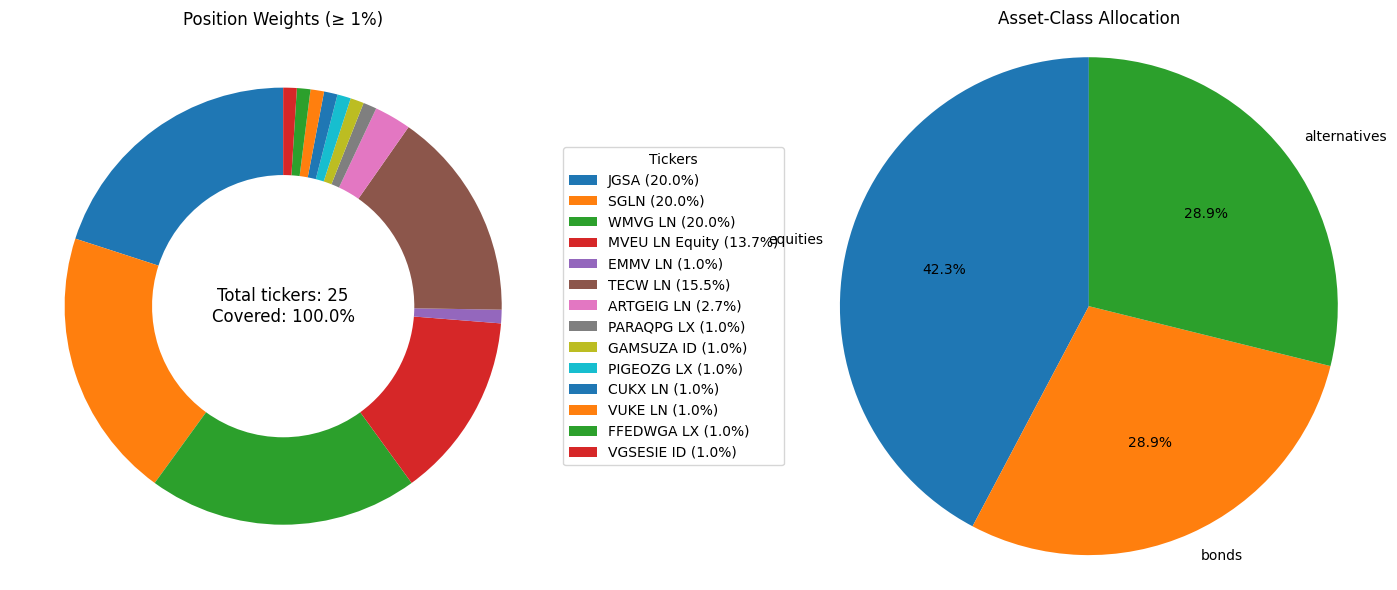

In [40]:
# 1) Filter & aggregate tiny slices (under 1%)
tol = 0.01  # 1%
weights = optimal_weights.copy()
labels  = np.array(df.columns)

mask      = weights >= tol
large_w   = weights[mask]
large_lbl = labels[mask]
small_sum = weights[~mask].sum()

# if there's anything to lump, append it as "Other"
if small_sum > 0:
    large_w   = np.append(large_w, small_sum)
    large_lbl = np.append(large_lbl, "Other")

# 2) Build legend labels with weights
legend_labels = [
    f"{lbl} ({wt:.1%})"
    for lbl, wt in zip(large_lbl, large_w)
]

# 3) Set explode so "Other" slice is offset
explode = [0.1 if lbl == "Other" else 0.0 for lbl in large_lbl]

# 4) Compute class-level weights
class_w = {
    cls: weights[asset_indices.get(cls, [])].sum()
    for cls in asset_limits
}
cls_labels  = list(class_w.keys())
cls_weights = list(class_w.values())

# 5) Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# — Donut of individual assets
wedges1, _ = ax1.pie(
    large_w,
    startangle=90,
    wedgeprops=dict(width=0.4),
    explode=explode,
    normalize=True
)
ax1.set_title("Position Weights (≥ 1%)")
ax1.legend(
    wedges1,
    legend_labels,
    title="Tickers",
    loc="center left",
    bbox_to_anchor=(1, 0, 1, 1)
)
# center text
ax1.text(
    0, 0,
    f"Total tickers: {len(weights)}\nCovered: {large_w.sum():.1%}",
    ha="center", va="center", fontsize=12
)

# — Pie of asset classes
wedges2, texts2, autotxts2 = ax2.pie(
    cls_weights,
    labels=cls_labels,
    autopct="%1.1f%%",
    startangle=90
)
ax2.set_title("Asset-Class Allocation")
ax2.axis("equal")

plt.tight_layout()
plt.show()

/Users/nachogutierrezdelaroza/Documents/2_PP/WM/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/nachogutierrezdelaroza/Documents/2_PP/WM/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/nachogutierrezdelaroza/Documents/2_PP/WM/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/Users/nachogutierrezdelaroza/Documents/2_PP/WM/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


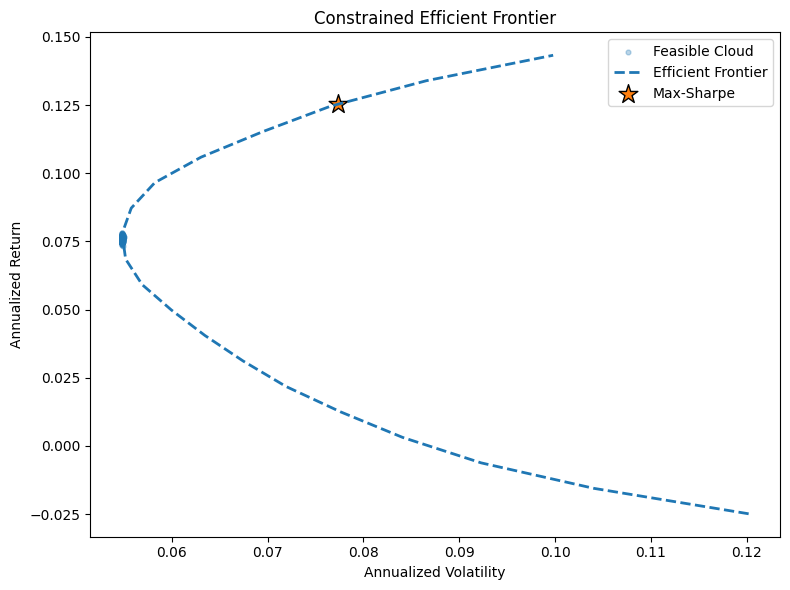

In [41]:
# Annualize your inputs
μ_daily = log_returns.mean(axis=0)
Σ_daily = np.cov(log_returns.T)
μ = μ_daily * 252
Σ = Σ_daily * 252

N = len(μ)
    
# 2) Helper: minimum-variance portfolio for a given target return R
def min_var_for_return(R):
    # add the return-matching constraint
    ret_cons = {
        "type": "eq",
        "fun":   lambda w, m=μ, R=R: w.dot(m) - R
    }
    cons = constraints + [ret_cons]
    x0 = np.ones(N) / N
    out = minimize(
        lambda w: w.dot(Σ).dot(w),
        x0=x0,
        method="SLSQP",
        bounds=bounds,
        constraints=cons
    )
    return out.x if out.success else None

# 3) Build a grid of target returns
R_min, R_max = μ.min(), μ.max()
R_grid = np.linspace(R_min, R_max, 40)

frontier = np.array([
    (np.sqrt(x.dot(Σ).dot(x)), x.dot(μ))
    for R in R_grid
    for x in [min_var_for_return(R)]
    if x is not None
])

# 4) Monte-Carlo feasible cloud
def simulate_cloud(n_sims=500):
    sims = []
    for _ in range(n_sims):
        # random start, then project into your feasible region
        w0 = np.random.dirichlet(np.ones(N))
        res = minimize(
            lambda w: w.dot(Σ).dot(w),
            x0=w0,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints
        )
        if res.success:
            μ_s = res.x.dot(μ)
            σ_s = np.sqrt(res.x.dot(Σ).dot(res.x))
            sims.append((σ_s, μ_s))
    return np.array(sims)

cloud = simulate_cloud(300)

# Plot
plt.figure(figsize=(8,6))

# cloud
plt.scatter(cloud[:,0], cloud[:,1], s=12, alpha=0.3, label="Feasible Cloud")

# analytic EF
plt.plot(frontier[:,0], frontier[:,1], linestyle="--", linewidth=2, label="Efficient Frontier")

# your max-Sharpe point
σ_opt = np.sqrt(optimal_weights.dot(Σ).dot(optimal_weights))
μ_opt = optimal_weights.dot(μ)
plt.scatter([σ_opt], [μ_opt], marker="*", s=200, label="Max‐Sharpe", edgecolor="k")

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Constrained Efficient Frontier")
plt.legend()
plt.tight_layout()
plt.show()